In [33]:
# read in packages
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, random_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

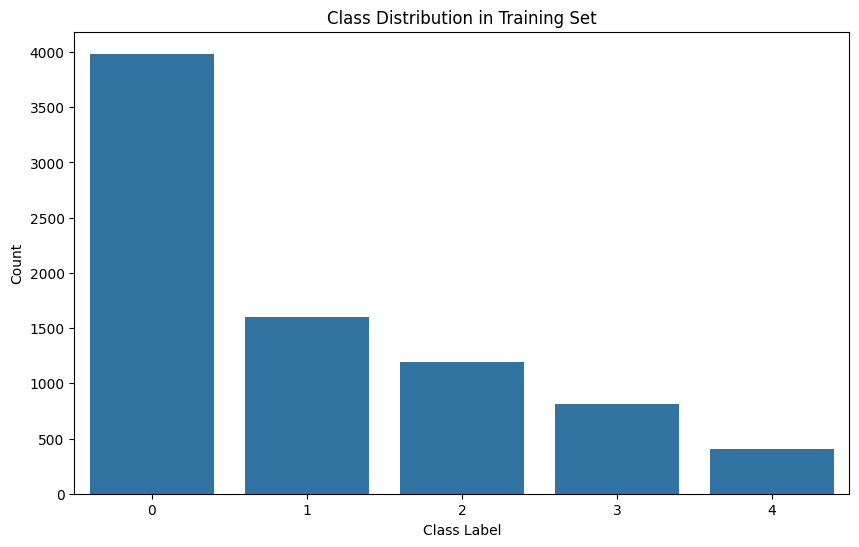

Label
0    3985
1    1604
2    1196
3     809
4     406
Name: count, dtype: int64
--- Train Set ---
Total examples: 8000
Batch Features shape: torch.Size([32, 206])
Batch Labels shape:   torch.Size([32])

--- Test Set ---
Total examples: 2000
Batch Features shape: torch.Size([32, 205])
Batch Labels shape:   torch.Size([32])



In [ ]:
# load dataset
class CSVDataset(Dataset):
    def __init__(self, csv_file_path):
        # Load the data using pandas
        self.df = pd.read_csv(csv_file_path)

        # last column is the label and others are features
        # Convert pandas DataFrame to numpy arrays, then to PyTorch tensors
        self.features = torch.from_numpy(self.df.iloc[:, :-1].values).float()
        self.labels = torch.from_numpy(self.df.iloc[:, -1].values).long()

    def __len__(self):
        # Return the number of rows in the DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Return a single sample (features and label) as tensors
        return self.features[idx], self.labels[idx]

# create dataset instances
train_dataset = CSVDataset('/Users/edmundtsou/Desktop/JHU Files/Sophomore/Neural Networks from Scratch/Neural-Network-from-Scratch-Mystery-Project/Data/train.csv')
test_dataset = CSVDataset('/Users/edmundtsou/Desktop/JHU Files/Sophomore/Neural Networks from Scratch/Neural-Network-from-Scratch-Mystery-Project/Data/test.csv')

# check for class imbalances
# Extract labels from the train dataset
train_labels = [label.item() for _, label in train_dataset]

df_labels = pd.DataFrame(train_labels, columns=['Label'])

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_labels, x='Label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

# Print exact counts
print(df_labels['Label'].value_counts().sort_index())

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loaders = [("Train", train_loader), ("Test", test_loader)]

# print dataset info
for loader_name, loader in loaders:
    print(f"--- {loader_name} Set ---")
    print(f"Total examples: {len(loader.dataset)}")
    
    # Check the first batch to get shapes
    for features, labels in loader:
        print(f"Batch Features shape: {features.shape}")
        print(f"Batch Labels shape:   {labels.shape}")
        break 
    print()



=== Fold 1 ===
              precision    recall  f1-score   support

           0      0.847     0.962     0.901       797
           1      0.801     0.844     0.822       320
           2      0.843     0.717     0.775       240
           3      0.719     0.506     0.594       162
           4      0.795     0.383     0.517        81

    accuracy                          0.826      1600
   macro avg      0.801     0.682     0.722      1600
weighted avg      0.821     0.826     0.816      1600


=== Fold 2 ===
              precision    recall  f1-score   support

           0      0.859     0.967     0.910       797
           1      0.838     0.857     0.847       321
           2      0.860     0.795     0.826       239
           3      0.858     0.599     0.705       162
           4      0.675     0.333     0.446        81

    accuracy                          0.850      1600
   macro avg      0.818     0.710     0.747      1600
weighted avg      0.845     0.850     0.841  

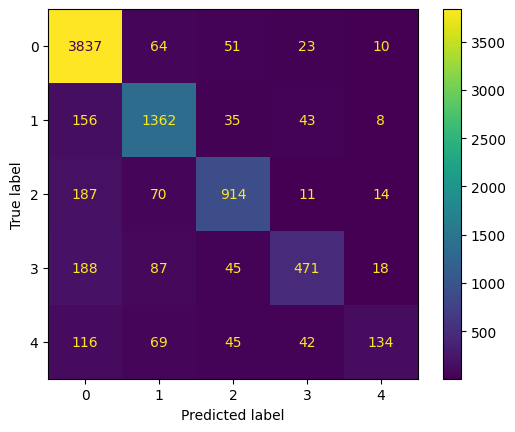

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

def dataloader_to_numpy(dl, max_batches=None, device="cpu"):
    Xs, ys = [], []
    for i, batch in enumerate(dl):
        if max_batches is not None and i >= max_batches:
            break

        if isinstance(batch, (list, tuple)):
            x, y = batch
        else:
            x, y = batch["x"], batch["y"]

        x = x.detach().to(device)
        y = y.detach().to(device)

        if x.ndim > 2:
            x = x.view(x.size(0), -1)

        Xs.append(x.cpu().numpy())
        ys.append(y.cpu().numpy())

    X = np.concatenate(Xs, axis=0)
    y = np.concatenate(ys, axis=0)
    return X, y
    
X, y = dataloader_to_numpy(train_loader)

K = int(np.max(y)) + 1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

all_preds = []
all_true  = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # compute class weights for current fold only
    classes = np.unique(y_train)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=y_train
    )
    class_weight_dict = dict(zip(classes.tolist(), class_weights.tolist()))

    sample_weights = np.array(
        [class_weight_dict[int(c)] for c in y_train],
        dtype=np.float32
    )

    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=K,
        eval_metric="mlogloss",
        n_estimators=660,
    )

    clf.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        eval_set=[(X_val, y_val)],
        verbose=False,
        
    )

    y_pred = clf.predict(X_val)

    all_preds.append(y_pred)
    all_true.append(y_val)

    print(classification_report(y_val, y_pred, digits=3))


from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_preds)

print("\n=== Cross-validated performance ===")
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

